### Imports and Definitions

In [1]:
from gzip import open as gopen
from math import log10
from matplotlib.patches import Patch
from os.path import isfile
from pickle import load,dump
from random import shuffle
from treeswift import read_tree_newick
import matplotlib.pyplot as plt
import seaborn as sns
TN93THRESH = 0.015

### Helper Function to Load FASTA

In [2]:
def read_FASTA(filename):
    seqs = {}
    name = None
    seq = ''
    if filename.lower().endswith('.gz'):
        f = gopen(filename)
    else:
        f = open(filename)
    for line in f:
        if isinstance(line,bytes):
            l = line.decode().strip()
        else:
            l = line.strip()
        if len(l) == 0:
            continue
        if l[0] == '>':
            if name is not None:
                assert len(seq) != 0, "Malformed FASTA"
                seqs[name] = seq
            name = l[1:]
            assert name not in seqs, "Duplicate sequence ID: %s" % name
            seq = ''
        else:
            seq += l
    f.close()
    assert name is not None and len(seq) != 0, "Malformed FASTA"
    seqs[name] = seq
    return seqs

### Helper Function to Load tn93 Output as Distance Matrix

In [3]:
def read_tn93(filename):
    dm = dict()
    if filename.lower().endswith('.gz'):
        f = gopen(filename)
    else:
        f = open(filename)
    for line in f:
        if isinstance(line,bytes):
            l = line.decode().strip()
        else:
            l = line.strip()
        u,v,d = l.split(',')
        if d == 'Distance':
            continue
        d = float(d)
        if u not in dm:
            dm[u] = dict()
        if v not in dm:
            dm[v] = dict()
        dm[u][v] = d; dm[v][u] = d
    return dm

### Helper Functions to Compute Cumulative Moving Average

In [4]:
# compute the average of a list of numbers
def avg(x):
    if len(x) == 0:
        return 0
    return sum(x)/len(x)

# get the Cumulative Moving Average (CMA) over all indices
def cma(x):
    y = [x[0]]
    for i in range(1,len(x)):
        y.append(y[-1]+x[i])
    for i in range(len(y)):
        y[i] /= (i+1)
    return y

# helper function to compute the test statistic
def cma_test_stat(y,miny,maxy):
    return (sum(y)-sum(miny))/sum(maxy)

# returns (stat,p,cma_dist,stat_dist). "side" is "left" or "right"
def cma_test(x,side,it=1000):
    assert side in {'left','right'}, "'side' must be 'left' or 'right'"
    y = cma(x)
    miny = cma(sorted(x))
    maxy = cma(sorted(x,reverse=True))
    stat = cma_test_stat(y,miny,maxy)
    cma_dist = list(); stat_dist = list()
    for _ in range(it):
        tmp = x[:]; shuffle(tmp); tmp_cma = cma(tmp)
        cma_dist.append(tmp_cma)
        stat_dist.append(cma_test_stat(tmp_cma,miny,maxy))
    if side == 'right':
        p = sum(e >= stat for e in stat_dist)/len(stat_dist)
    elif side == 'left':
        p = sum(e <= stat for e in stat_dist)/len(stat_dist)
    return stat,p,cma_dist,stat_dist

### Load Data

In [5]:
data = {
    'seqs': read_FASTA('../real_data/sd.full.aln.gz'),
    'tn93': read_tn93('../real_data/sd.full.tn93.csv.gz'),
    'time': {t:{l.decode().strip().split()[0]:int(l.decode().strip().split()[1]) for l in gopen('../real_data/sd.time.%s.tsv.gz'%t)} for t in ['sample','diagnosis','infection']},
    'proact': {n:{t:{s:{m:gopen('../real_data/sd.%s.%s.mv.proact.%s.%s.txt.gz'%(n,t,s,m)).read().decode().strip().splitlines() for m in ['feedback','oldmode']} for s in ['sample']} for t in ['ft','iq']} for n in ['10','20','30','40','50','60','70','80','90','full']}
}
meta = {
    'label': {
        'ft': 'FastTree',
        'iq': 'IQ-TREE',
        'feedback': 'ProACT (Feedback)',
        'oldmode': 'ProACT (No Feedback)'
    }
}

## Metric: 1/(average time between me and HIV-TRACE link)

### Cumulative Moving Average (CMA) Test

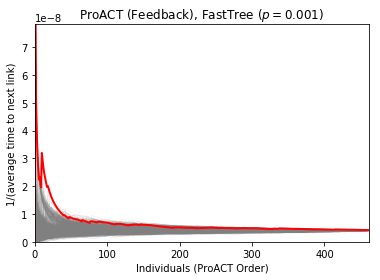

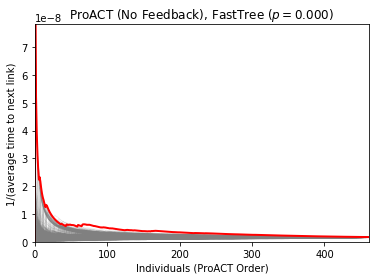

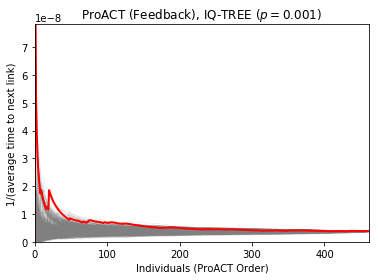

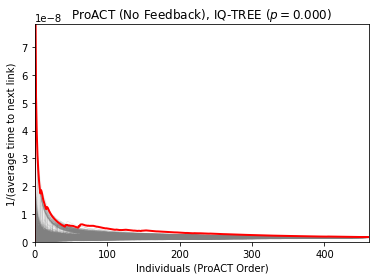

In [6]:
IT = 1000
for per in ['50']: # only doing median
    END = max(int(l.split('_')[-1]) for l in data['proact'][per]['ft']['sample']['feedback'])
    for t in ['ft','iq']:
        for s in ['sample']:
            for m in ['feedback','oldmode']:
                fig = plt.figure()
                x = list(range(len(data['proact'][per][t][s][m])))
                val = [avg([data['time'][s][v]-data['time'][s][u] for v in data['tn93'][u] if data['tn93'][u][v] <= TN93THRESH and data['time'][s][v] > END]) if u in data['tn93'] else 0 for u in data['proact'][per][t][s][m]]
                val = [0 if e == 0 else 1./e for e in val]
                y = cma(val)
                stat,p,cma_dist,stat_dist = cma_test(val,'right',it=IT)
                for bg in cma_dist[:min(len(cma_dist),1000)]:
                    plt.plot(x,bg,color='grey',linewidth=0.5,alpha=0.2)
                plt.plot(x,y,color='red',linewidth=2)
                plt.xlim(xmin=0,xmax=max(x))
                plt.ylim(ymin=0,ymax=max(y))
                pstr = "{:.{}f}".format(p,int(log10(IT)))
                plt.title(r"%s, %s ($p=%s$)"%(meta['label'][m],meta['label'][t],pstr))
                plt.xlabel("Individuals (ProACT Order)")
                plt.ylabel("1/(average time to next link)")
                fig.savefig('results.cmatest.%s.%s.pdf'%(meta['label'][m],meta['label'][t]), format='pdf', bbox_inches='tight')

### Pairwise Test